In [50]:
import pandas as pd
from collections import defaultdict
import numpy as np

In [51]:
def main(csv_file):
    """
    Given an appropriate csv_file, output the relevant columns.

    Returns df with columns [user, start, end, normalized_company, industry]
    """

    employ_data = pd.read_csv(csv_file, sep="\t", header=None,
                              names=[i for i in range(34)], low_memory=False)
    # column info from taxonomy file
    name = ['user', 'name', 'birth', 'gender', 'primary',
            'primary_weight', 'secondary', 'secondary_weight',
            'city', 'country', 'education', 'elite', 'start',
            '.', 'end', '??', '/', 'length', 'role', 'department',
            'company', 'normalized_company', 'ticker', 'exchange',
            'public', 'location_company', 'industry', 'educational',
            'degree', 'elite_education', 'major', 'department', 'FIGI',
            'last_update']
#     drop = ['length', 'gender', 'primary',
#         'primary_weight', 'secondary', 'secondary_weight',
#         'city', 'country', 'education', 'elite', '.', '??',
#         '/', 'department', 'exchange',
#         'public', 'location_company', 'educational', 'degree', 'elite_education',
#         'major', 'department', 'FIGI', 'last_update']
    employ_data.columns = name
    return employ_data


# data without datetime features, and none values for some dates
raw_data = {'db': main('./Data/DB_profiles.csv'),
            'gs': main('./Data/GS_profiles.csv'),
            'leh': main('./Data/LEH_profiles.csv'),
            'ms': main('./Data/MS_profiles.csv'),
            'ubs': main('./Data/UBS_profiles.csv')
            }

In [168]:
leh[leh.user == 'c166dfbb-635e-350d-bb01-6dd831239ad8'].loc[:, ['start', 'end', 'company']]

,start,end,company
40336,1986-01-01,1990-01-01,-
40337,1990-01-01,1993-12-01,TIME_OFF
40338,1994-01-01,2004-08-01,Morgan Stanley
40339,2004-08-01,2006-03-01,Credit Suisse
40340,2006-01-01,2008-01-01,Morgan Stanley
40341,2007-03-01,2009-03-01,Lehman Brothers
40342,2009-03-01,2016-08-01,Citigroup
40343,2016-09-01,2018-01-01,"PM Strategic Solutions, LLC"
40344,2018-02-01,2018-01-01,Barclays Investment Bank


In [167]:
ms[ms.user == 'c166dfbb-635e-350d-bb01-6dd831239ad8'].loc[:, ['start', 'end', 'company']]

,start,end,company
53819,1986-01-01,1990-01-01,-
53820,1990-01-01,1993-12-01,TIME_OFF
53821,1994-01-01,2004-08-01,Morgan Stanley
53822,2004-08-01,2006-03-01,Credit Suisse
53823,2006-01-01,2008-01-01,Morgan Stanley
53824,2007-03-01,2009-03-01,Lehman Brothers
53825,2009-03-01,2016-08-01,Citigroup
53826,2016-09-01,2018-01-01,"PM Strategic Solutions, LLC"
53827,2018-02-01,2018-01-01,Barclays Investment Bank


In [159]:
leh = raw_data['leh']

In [162]:
ms = raw_data['ms']

In [ ]:
def standardize_dates(company, missing_start = '1900-01-01', missing_end = '2018-01-01'):
    """
    Converts start date and end date to datetime objects, and converts None values to the specified missing 
    dates.

    Returns the modified dataframe
    """
    company_data = raw_data[company].copy()
    company_data['start'] = company_data['start'].str.replace('None', missing_start)
    company_data['end'] = company_data['end'].str.replace('None', missing_end)
    company_data['start'] = pd.to_datetime(company_data['start'])
    company_data['end'] = pd.to_datetime(company_data['end'])
    return company_data


# set up dictionary to hold data for each company

for company in raw_data.keys():
    raw_data[company] = standardize_dates(company)

In [53]:
def get_users(company_name, company_data, worked_date = '2008-01-01', missing_start = '1900-01-01', missing_end = '2018-01-01'):
    """"
    Returns the users who worked at a given company on worked_date, that does not have both start and
    end dates missing
    
    worked_date: string specifying the date on which to extract employees from. 
                 Must be coercible into a datetime object
    missing_start: default value for missing start dates
    missing_end: default value for missing end dates
    """
    worked_date = pd.to_datetime(worked_date)
    missing_start = pd.to_datetime(missing_start)
    missing_end = pd.to_datetime(missing_end)
    x = company_data
    
    company_tickers = {'db': 'DB', 'leh': 'LEH', 'gs': 'GS', 'ms': 'MS^E', 'ubs': 'UBS'}
    # conditions: start and end not both missing, worked before/after 2008-01-01, ticker matches company
    mask = ~((x['start'] == missing_start) & (x['end'] == missing_end)) & \
        (x['start'] < worked_date) & \
        (x['end'] > worked_date) & \
        (x['ticker'] == company_tickers[company_name])
    return company_data[mask]['user'].unique()


# gets the user_ids within each company that match the conditioning, before and and after
#   2008-01-01, exclusive
users = {company_name: get_users(company_name, company_data) for company_name, company_data in raw_data.items()}

In [54]:
data = {}
for company, company_data in raw_data.items():
    company_users = users[company]
    data[company] = company_data[company_data['user'].isin(company_users)]

# Missing industries

In [55]:
# read all the csv files
profile = pd.read_csv('./Data/profile_industry_mappings.csv', header=None, names=[i for i in range(5)], dtype={4: str})
profile.drop([0, 2], axis='columns', inplace=True)
profile.rename(mapper={1: 'company', 3: 'norm', 4: "ind"}, axis='columns', inplace=True)

mturk = pd.read_csv('./Data/industries_MTurkers_20170711.csv', header=None, encoding='latin-1')
mturk.drop([1], axis='columns', inplace=True)
mturk.rename(mapper={0: 'company', 2: "ind"}, axis='columns', inplace=True)

finance = pd.read_csv('./Data/Finance.csv', dtype={'Industry': str})
finance.drop([finance.columns[0], finance.columns[2], finance.columns[4]], axis='columns', inplace=True)
finance.rename(mapper={'Normalized Company Name': 'norm', 'Industry': "ind"}, axis='columns', inplace=True)

manual = pd.read_csv('./Data/manual_industry_mappings.csv', encoding='latin-1', header=None, dtype={2: str})
manual.drop([1], axis='columns', inplace=True)
manual.rename(mapper={0: 'norm', 2: "ind"}, axis='columns', inplace=True)

industries_2019 = pd.read_csv('./Data/missing_industries_2019.csv', header=None, dtype={2: str})
industries_2019 = industries_2019[~(industries_2019[1] == 1)].copy()

industries_2019.drop([1], axis = 'columns', inplace = True)
industries_2019.rename(mapper={0: 'company', 2: "ind"}, axis='columns', inplace=True)
industries_2019 = industries_2019[~pd.isnull(industries_2019.ind)].copy()

In [56]:
#mturk industry is given as "ind_x", profile industry is given as "ind_y"
company_comb = pd.merge(mturk, profile, on='company', how='outer')
#prioritize mturk data
company_comb['combined'] = company_comb['ind_x'].combine_first(company_comb['ind_y'])

#mturk industry is given as "ind", profile industry is given as "combined"
company_comb = pd.merge(industries_2019, company_comb, on='company', how='outer')
#prioritize manual entry data
company_comb['combined'] = company_comb['ind'].combine_first(company_comb['combined'])

In [57]:
#merge manual and finance files, prioritizing manual
norm_comb = pd.merge(manual, finance, on = 'norm', how = 'outer')
norm_comb['combined'] = norm_comb['ind_x'].combine_first(norm_comb['ind_y'])
#merge manual/finance and profile[norm], prioritizing manual/finance
norm_comb = pd.merge(norm_comb, profile, on = 'norm', how = 'outer')
norm_comb['combined'] = norm_comb['combined'].combine_first(norm_comb['ind'])

In [58]:
# convert the columns of the aggredated dataframe into a dictionary where the key is the company name
# and the value is the industry code
norm_mapping = dict(zip(norm_comb.norm, norm_comb.combined))
company_mapping = dict(zip(company_comb.company, company_comb.combined))
# set the default value if the company is not found to NaN
norm_mapping = defaultdict(lambda: np.NaN, norm_mapping)
company_mapping = defaultdict(lambda: np.NaN, company_mapping)

In [59]:
def filter_manual(company_data):
    """
    Adds industry labels to entries that don't have one, based on the manual industry data
    """
    company_data = company_data.copy()
    # convert to lowercase for more accurate matching
    company_data['normalized_company_lower'] = company_data['normalized_company'].str.lower()
    company_data['company_lower'] = company_data['company'].str.lower()
    # apply norm_mapping and company_mapping to upper and lower case versions
    company_data['company_mapped'] = company_data['company'].apply(lambda y: company_mapping[y])
    company_data['normalized_company_mapped'] = company_data['normalized_company'].apply(lambda y: norm_mapping[y])
    company_data['company_lower_mapped'] = company_data['normalized_company_lower'].apply(lambda y: norm_mapping[y])
    company_data['normalized_company_lower_mapped'] = company_data['normalized_company_lower'].apply(lambda y: norm_mapping[y])
    # combines all mappings. Prioritize Existing industry code > MTurk/profle(company) > 
    # manual/finance/profile(normalized_company) > manual/finance/profile(normalized_company_lower) 
    company_data['industry_two'] = company_data['industry'].combine_first(company_data['company_mapped'])
    company_data['industry_three'] = company_data['industry_two'].combine_first(company_data['normalized_company_mapped'])
    company_data['industry_four'] = company_data['industry_three'].combine_first(company_data['company_lower_mapped'])
    company_data['industry_five'] = company_data['industry_four'].combine_first(company_data['normalized_company_lower_mapped'])
    company_data['industry'] = company_data['industry_five']
    # drop the temporary columns
    company_data.drop(['normalized_company_lower', 'company_lower', 'company_mapped', 'normalized_company_mapped', 'company_lower_mapped','normalized_company_lower_mapped', 'industry_two', 'industry_three', 'industry_four','industry_five'], axis=1, inplace=True)
    return company_data

def mask(company_data):
    """
    Return values in the time range with start before '2016-1-1' and end after '2016-1-1'.

    Excludes values that don't have a start or end time, or are educational.
    """
    mask = (company_data['start'] <= pd.to_datetime('2016-1-1')) & (company_data['end'] >= pd.to_datetime('2016-1-1')) & ~((company_data['start'] == pd.to_datetime('1900-01-01')) & (company_data['end'] == pd.to_datetime('2018-01-01'))) & (~company_data['ticker'].isin(['UNIVERSITY', 'SCHOOL']) & ~(company_data.educational))
    #& ~(pd.isnull(company_data.industry))
    return company_data[mask]


def filter_and_mask(company_data):
    # combines filter and mask
    filtered = filter_manual(company_data)
    return mask(filtered)


# Missing Industry

In [60]:
# def mask_missing(company_data):
#     """
#     Return values in the time range with start before '2016-1-1' and end after '2016-1-1'.

#     Excludes values that don't have a start or end time.
#     """
    
#     mask = (company_data['start'] < pd.to_datetime('2016-1-1')) & (company_data['end'] > pd.to_datetime('2016-1-1')) & (company_data['start'] != pd.to_datetime('1900-01-01')) & (~company_data['ticker'].isin(['UNIVERSITY', 'TIME_OFF', 'SCHOOL', 'MISSING', 'FREELANCE', 'UNEMPLOYED', 'RETIRED']))
#     return company_data[mask]

# all_data =  pd.concat(raw_data.values())

# company_data = mask_missing(all_data).copy()

# company_data['normalized_company_lower'] = company_data['normalized_company'].str.lower()
# company_data['company_lower'] = company_data['company'].str.lower()
# # apply norm_mapping and company_mapping to upper and lower case versions
# company_data['company_mapped'] = company_data['company'].apply(lambda y: company_mapping[y])
# company_data['normalized_company_mapped'] = company_data['normalized_company'].apply(lambda y: norm_mapping[y])
# company_data['company_lower_mapped'] = company_data['normalized_company_lower'].apply(lambda y: norm_mapping[y])
# company_data['normalized_company_lower_mapped'] = company_data['normalized_company_lower'].apply(lambda y: norm_mapping[y])
# # combines all mappings. Prioritize Existing industry code > MTurk/profle(company) > 
# # manual/finance/profile(normalized_company) > manual/finance/profile(normalized_company_lower) 
# company_data['industry_two'] = company_data['industry'].combine_first(company_data['company_mapped'])
# company_data['industry_three'] = company_data['industry_two'].combine_first(company_data['normalized_company_mapped'])
# company_data['industry_four'] = company_data['industry_three'].combine_first(company_data['company_lower_mapped'])
# company_data['industry_five'] = company_data['industry_four'].combine_first(company_data['normalized_company_lower_mapped'])
# company_data['industry'] = company_data['industry_five']
# # drop the temporary columns
# company_data.drop(['company_mapped', 'normalized_company_mapped', 'company_lower_mapped','normalized_company_lower_mapped', 'industry_two', 'industry_three', 'industry_four','industry_five'], axis=1, inplace=True)

# x = company_data.groupby('user').last()
# most_recent_missing = x[pd.isnull(x['industry'])]

#most_recent_missing['company'].value_counts().to_csv('./Deliverables/missing_values.csv')

# Matching with missing job entries as of 2016-1-1

In [61]:
# begin matching on job titles, prepare data by dropping irrelevant names
drop = ['length', 'gender', 'primary',
        'primary_weight', 'secondary', 'secondary_weight',
        'city', 'country', 'education', 'elite', '.', '??',
        '/', 'department', 'exchange',
        'public', 'location_company', 'educational', 'degree', 'elite_education',
        'major', 'department', 'FIGI', 'last_update', 'industry', 'birth', 'company']
matching_data = {company_name: company_data.drop(labels=drop, axis=1) for company_name, company_data in data.items()}


def job_2008(company_name, company_data):
    """"
    Return each user's job at the given company as of 2008-01-01
    """
    date_2008 = pd.to_datetime('2008-01-01')
    missing_start = pd.to_datetime('1900-01-01')
    missing_end = pd.to_datetime('2018-01-01')

    company_tickers = {'db': 'DB', 'leh': 'LEH', 'gs': 'GS', 'ms': 'MS^E', 'ubs': 'UBS'}

    x = company_data
    mask = ~((x['start'] == missing_start) & (x['end'] == missing_end)) & \
           (x['start'] < date_2008) & \
           (x['end'] > date_2008) & \
           (x['ticker'] == company_tickers[company_name])
    return company_data[mask]


job_as_of_2008 = {company_name: job_2008(company_name, company_data) for company_name, company_data in
                  matching_data.items()}

In [62]:
all_data = pd.concat(job_as_of_2008.values())
# only person missing a role in the entire data set
all_data = all_data.drop(11512)

# begin extracting job titles
directors = set(all_data[(all_data.role.str.contains(r'director|MD,md', case=False))
                         | (all_data.role.str.match(r'ed|md', case=False))].user)
all_roles = directors.copy()

analysts = set(all_data[all_data.role.str.contains('analyst|Anaylst', case=False)].user).difference(all_roles)
all_roles = all_roles.union(analysts)

vps = set(all_data[all_data.role.str.contains('president|vp', case=False)].user).difference(all_roles)
all_roles = all_roles.union(vps)

assocs = set(all_data[all_data.role.str.contains('associate', case=False)].user).difference(all_roles)
all_roles = all_roles.union(assocs)

accountants = set(
    all_data[all_data.role.str.contains('accountant|account executive|accounting', case=False)].user).difference(
    all_roles)
all_roles = all_roles.union(accountants)

consultants = set(all_data[all_data.role.str.contains('consultant', case=False)].user).difference(all_roles)
all_roles = all_roles.union(consultants)

missing = set(all_data[all_data.role.str.match(r'-|\?|\.', case=False)].user).difference(all_roles)
all_roles = all_roles.union(missing)

developers = set(
    all_data[all_data.role.str.contains(r'developer|engineer|system administrator', case=False)].user).difference(
    all_roles)
all_roles = all_roles.union(developers)

interns = set(all_data[all_data.role.str.contains('intern|trainee|apprentice', case=False)].user).difference(all_roles)
all_roles = all_roles.union(interns)

specialists = set(
    all_data[all_data.role.str.contains('specialist|administrator|research|expert', case=False)].user).difference(
    all_roles)
all_roles = all_roles.union(specialists)

sales = set(all_data[all_data.role.str.contains('sales', case=False)].user).difference(all_roles)
all_roles = all_roles.union(sales)

traders = set(all_data[all_data.role.str.contains(r'trader|trading|Portfolio Management', case=False)].user).difference(
    all_roles)
all_roles = all_roles.union(traders)

bankers = set(all_data[all_data.role.str.contains(r'banking|banker|finance', case=False)].user).difference(all_roles)
all_roles = all_roles.union(bankers)

controllers = set(all_data[all_data.role.str.contains('controller', case=False)].user).difference(all_roles)
all_roles = all_roles.union(controllers)

partners = set(all_data[all_data.role.str.contains('partner', case=False)].user).difference(all_roles)
all_roles = all_roles.union(partners)

counsels = set(all_data[all_data.role.str.contains('counsel', case=False)].user).difference(all_roles)
all_roles = all_roles.union(counsels)

recruiters = set(all_data[all_data.role.str.contains('recruiter|human resources', case=False)].user).difference(
    all_roles)
all_roles = all_roles.union(recruiters)

advisors = set(all_data[all_data.role.str.contains('advisor|adviseur', case=False)].user).difference(all_roles)
all_roles = all_roles.union(advisors)

assistants = set(
    all_data[all_data.role.str.contains('assistant|support|services|receptionist', case=False)].user).difference(
    all_roles)
all_roles = all_roles.union(assistants)

managers = set(all_data[all_data.role.str.contains(
    r'manager|supervisor|team lead|head|lead|coordinator|representative|process executive',
    case=False)].user).difference(all_roles)
all_roles = all_roles.union(managers)

others = set(all_data.user).difference(all_roles)

# zip all sets and all job title names
all_sets = [directors, analysts, vps, assocs, advisors, assistants, consultants, managers, missing, developers, interns,
            specialists, sales, traders, bankers, controllers, partners, counsels, recruiters, accountants, others]
job_titles = ['director', 'analyst', 'vp', 'assoc', 'advisor', 'assistant', 'consultant', 'manager', 'missing',
              'developer', 'intern', 'specialist', 'sale', 'trader', 'banker', 'controller', 'partner', 'counsel',
              'recruiter', 'accountant', 'other']

zipped = list(zip(all_sets, job_titles))


def to_dict(dictionary, users, job_title):
    """Map users to job_title in the given dictionary"""
    for user in users:
        dictionary.update({user: job_title})


full_mapping = {}
[to_dict(full_mapping, x, y) for x, y in zipped]
full_mapping.update({'c0a3eb6a-59db-3a30-8a39-99a7cc8b9ce1': 'specialist'})
full_mapping.update({'5f425323-1cdf-3e81-a08e-35b483c42da9': 'missing'})

# Logistic Regression

In [150]:
import statsmodels.discrete.discrete_model as sm
# prepare data for regression by dropping irrelevant names
drop = ['length', 'name',
        'primary_weight', 'secondary', 'secondary_weight', 'elite_education',
        'city', 'country', '.', '??',
        '/', 'department', 'exchange',
        'public', 'location_company',
        'major', 'department', 'FIGI', 'last_update', 'degree']

regression_data = {company_name: company_data.drop(labels=drop, axis=1) for company_name, company_data in data.items()}

In [151]:
#additional step of filtering out those who don't have a job entry on 2016-1-1
all_data_2016 = pd.concat(regression_data.values())
employed_2016 = filter_and_mask(all_data_2016)
employ_2016_users = list(employed_2016.user.unique())

In [152]:
regression_data = {company_name: job_2008(company_name, company_data) for company_name, company_data in
                   regression_data.items()}

In [153]:
non_lehman = pd.concat([regression_data['db'], regression_data['gs'], regression_data['ms'], regression_data['ubs']])
non_lehman['is_lehman'] = 0

lehman = regression_data['leh'].copy()
lehman['is_lehman'] = 1

all_data = pd.concat([lehman, non_lehman])

all_data = all_data[all_data.user.isin(employ_2016_users)]

# fill in missing births to the median date, 1976
index = all_data[all_data.birth.isin(['None', '2000'])].index
all_data.loc[index, ['birth']] = '1976'

In [154]:
import pickle
with open('./Data/my_all_data', 'wb') as handle:
    pickle.dump(all_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [103]:
all_data = all_data.groupby('user').first().reset_index()

In [ ]:
## import pickle
# with open('./Data/employed_2016.csv', 'wb') as handle:
#     pickle.dump(employ_2016_users, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Informative skills

In [155]:
skills = list(all_data.primary.value_counts().index)

import scipy.stats as st

#all_data = all_data[~(all_data['primary'] == '-1')].copy()
p_lehman = len(all_data[all_data.is_lehman == 1]) / len(all_data)
p_other = 1 - p_lehman
entropy_parent = - (p_lehman * np.log2(p_lehman) + p_other * np.log2(p_other))
n = len(all_data)

In [156]:
entropy_parent

0.5296042464864098

In [108]:
len(all_data[all_data.is_lehman == 1])

9631

In [107]:
n

78944

In [104]:
IG = []
for skill in skills:
    split = all_data[all_data.primary == skill]
    split_no = all_data[~(all_data.primary == skill)]
    
    #look at people with the skill first
#     p_split_lehman = sum(split.is_lehman)/len(split)
#     p_split_other = 1 - p_split_lehman

    #entropy_split = - (p_split_lehman * np.log2(p_split_lehman) + p_split_other * np.log2(p_split_other))
    split_lehman = sum(split.is_lehman)
    split_other = len(split) - split_lehman
    entropy_split = st.entropy([split_lehman, split_other],base=2)
    
    #look at people without the skill next
#     p_no_lehman = sum(split_no.is_lehman)/len(split_no)
#     p_no_other = 1 - p_no_lehman

    #entropy_no_split = - (p_no_lehman * np.log2(p_no_lehman) + p_no_other * np.log2(p_no_other))
    no_lehman = sum(split_no.is_lehman)
    no_other = len(split_no) - no_lehman
    entropy_no_split = st.entropy([no_lehman, no_other],base=2)
    
    #weight by number in each split
    left = len(split)
    right = len(split_no)
    entropy_children = left/n * entropy_split + right/n * entropy_no_split
    
    IG.append(entropy_parent - entropy_children)

IG

[0.00019695009174303113,
 5.35514151390748e-05,
 0.0014392526215359913,
 6.097171460184292e-05,
 6.945361563526209e-05,
 0.0011049419905402313,
 0.00028247005131465386,
 3.257022205960247e-05,
 7.953333267196605e-06,
 5.056339443632041e-05,
 1.4344209153804854e-09,
 4.410118045194977e-06,
 2.3403978382074975e-05,
 3.3794879658377575e-05,
 0.00011884255057970083,
 1.702835100692024e-05,
 2.7017610122470614e-06,
 4.157502692336834e-06,
 0.0002494516435149752,
 0.00010494124195925547,
 2.0695139602011636e-08,
 1.5447665054901805e-06,
 4.272474412014837e-05,
 7.701866355358522e-05,
 1.0291138953899548e-05,
 5.593861648456322e-05,
 9.317082565574175e-06,
 1.4899117720901245e-05,
 5.610014812695852e-07,
 4.30118522509737e-06,
 1.9723721245146209e-07,
 3.922064647166046e-05,
 1.4063658483109975e-05,
 7.4488171990516605e-06,
 2.741270731521084e-07,
 2.9621454570194494e-05,
 1.2409879581731786e-06,
 2.4441246138096062e-08,
 2.101367875151361e-06,
 3.754306165903998e-05,
 1.9675161581078626e-06,

In [105]:
best_with_missing = np.flip(np.argsort(IG))
# best_with_out_missing = np.flip(np.argsort(IG))

# best_with_out_missing
skills

['-1',
 'Banking and Finance',
 'Operations Management',
 'Technical Product Management',
 'Software Engineering',
 'Insurance',
 'Business Development',
 'Accounting and Auditing',
 'Middle Management',
 'Administration',
 'Recruiting',
 'IT Management and Support',
 'Social Media and Communications',
 'Web Development',
 'Human Resources (Senior)',
 'Sales Management',
 'CRM and Sales Management',
 'Digital Marketing',
 'Product Management',
 'Real Estate',
 'Legal',
 'Human Resources (Junior)',
 'Data Analysis',
 'Mobile Telecommunications',
 'Sales',
 'Non-Profit and Community',
 'Logistics',
 'Military',
 'Public Policy',
 'Graphic Design',
 'Hospitality',
 'Industrial Management',
 'Video and Film Production',
 'Web Design',
 'Personal Coaching',
 'Construction Management',
 'Education',
 'Healthcare',
 'Energy, Oil, and Gas',
 'Musical Production',
 'Retail and Fashion',
 'Visual Design',
 'Electrical Engineering',
 'Pharmaceutical',
 'Manufacturing and Process Management']

# Continuing regression

In [71]:
# data deemed informative by information gain. Missing is coded as '-1'
informative_skills = skills[0:5]
informative_skills = ['-1', 'Banking and Finance', 'Software Engineering', 'Technical Product Management','Real Estate']
# convert uninformative skills to '0'
not_informative = ~all_data.primary.isin(informative_skills)
all_data.loc[not_informative, 'primary'] = 0
all_data['job_category'] = all_data.user.apply(lambda x: full_mapping[x])

# make sure typing is consistent for each category
X = all_data[['birth', 'gender', 'primary', 'education', 'elite']].copy()
X['education'] = X['education'].apply(str)
X['gender'] = X['gender'].apply(str)
X['birth'] = X['birth'].astype(int)
X['elite'] = X['elite'].astype(int)
X = pd.get_dummies(data=X, drop_first=True)
X = sm.tools.add_constant(X)

y = all_data['is_lehman']

# regress y on X
logit = sm.Logit(y, X)
results = logit.fit(maxiter = 100)

# get propensities
all_data['propensity'] = results.predict(X)

# Begin matching process. Map each user to its propensity
user_to_propensity = dict(zip(all_data.user, all_data.propensity))

# get lehman and non-lehman guys
lehman = all_data[all_data['is_lehman'] == 1]
non_lehman = all_data[all_data['is_lehman'] == 0]

Optimization terminated successfully.
         Current function value: 0.367848
         Iterations 7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [72]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              is_lehman   No. Observations:                78944
Model:                          Logit   Df Residuals:                    78927
Method:                           MLE   Df Model:                           16
Date:                Mon, 23 Dec 2019   Pseudo R-squ.:                0.008194
Time:                        18:28:22   Log-Likelihood:                -29039.
converged:                       True   LL-Null:                       -29279.
Covariance Type:            nonrobust   LLR p-value:                 6.031e-92
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  -31.1210      3.142     -9.904      0.000     -37.280     -24.962
birth                                    0.0146      0.002      9.199      0.000       0.012       0.018
elite                                    0.2208      0.032      6.872      0.000       0.158       0.284
gender_1                                -0.2296      0.032     -7.098      0.000      -0.293      -0.166
gender_2                                -0.1698      0.027     -6.295      0.000      -0.223      -0.117
primary_-1                               0.3875      0.038     10.302      0.000       0.314       0.461
primary_Banking and Finance              0.3901      0.043      9.154      0.000       0.307       0.474
primary_Real Estate                      1.0716      0.201      5.333      0.000       0.678       1.465
primary_Software Engineering             0.5588      0.087      6.424      0.000       0.388       0.729
primary_Technical Product Management     0.5578      0.084      6.661      0.000       0.394       0.722
education_1                             -0.2821      0.115     -2.456      0.014      -0.507      -0.057
education_2                             -0.5514      0.197     -2.803      0.005      -0.937      -0.166
education_3                              0.1789      0.164      1.088      0.277      -0.143       0.501
education_4                              0.0580      0.027      2.132      0.033       0.005       0.111
education_5                             -0.0886      0.039     -2.259      0.024      -0.165      -0.012
education_6                              0.2215      0.039      5.736      0.000       0.146       0.297
education_7                              0.2099      0.063      3.334      0.001       0.086       0.333
========================================================================================================
"""

In [73]:
np.mean(X.birth)

1974.6611015403323

In [74]:
def get_closest(row):
    # return user ID of closest match with the same job title
    role = row.job_category
    score = row.propensity
    others_by_role = non_lehman[non_lehman.job_category == role].set_index('user')
    return np.absolute(others_by_role['propensity'] - score).idxmin()


# get closest match for each lehman guy
lehman['match'] = lehman.apply(get_closest, axis=1)
lehman['match_propensity'] = lehman.match.apply(lambda x: user_to_propensity[x])

lehman_matches = lehman

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


# Naive proportion finance

In [75]:
drop = ['length', 'gender', 'primary',
        'primary_weight', 'secondary', 'secondary_weight',
        'city', 'country', 'education', 'elite', '.', '??',
        '/', 'department', 'exchange',
        'public', 'location_company', 'degree', 'elite_education',
        'major', 'department', 'FIGI', 'last_update']

finance_data = {company_name : company_data.drop(labels=drop, axis=1) for company_name, company_data in data.items()}

def prop_finance(company_data):
    # exclude values with tickers in the categories
    copy = company_data.copy()
    users = company_data.groupby('user')
    total_users = len(users)
    # get each person's most recent job
    recent_jobs = users.first()
    # sum the people who stayed in finance industries
    stayed_finance = sum(recent_jobs['industry'].str.startswith('52', na=False))
    return stayed_finance, total_users, stayed_finance/total_users

# Apply mappings for missing industries with the dictionary, then mask to look only at job entries that start before
# '2016-1-1' and end after '2016-1-1'.
filtered_data = {company_name: filter_and_mask(company_data) for company_name, company_data in finance_data.items()}

# calculate the proportion that stayed in finance as of 2016-01-01
prop_stayed_finance = {company_name: prop_finance(company_data) for company_name, company_data in filtered_data.items()}
prop_stayed_finance

# # same as before, but don't filter the data with the dictionary
# filtered_data = {company_name: mask(company_data) for company_name, company_data in finance_data.items()}
# prop_unfiltered = {company_name: prop_finance(company_data) for company_name, company_data in filtered_data.items()}
# prop_unfiltered

{'db': (10216, 17696, 0.5773056057866185),
 'gs': (6850, 12130, 0.5647155812036274),
 'leh': (5391, 9631, 0.559754957948292),
 'ms': (9727, 16270, 0.5978488014751075),
 'ubs': (13373, 23229, 0.5757027853114641)}

# Matched proportion stayed in finance

In [76]:
lehman_to_match = dict(zip(lehman_matches.user, lehman_matches.match))

lehman = filtered_data['leh'].copy()
lehman['match'] = lehman.user.apply(lambda x : lehman_to_match[x])

matched_users = list(lehman.match.unique())

non_lehman =  pd.concat([filtered_data['db'], filtered_data['gs'], filtered_data['ms'], filtered_data['ubs']])
matches = non_lehman[non_lehman.user.isin(matched_users)]

matches = matches.groupby('user').first().reset_index()
matches['stayed_finance'] = matches['industry'].str.startswith('52', na=False)

In [77]:
match_to_stayed_finance = dict(zip(matches.user, matches.stayed_finance))
match_to_missing_industry = dict(zip(matches.user, pd.isnull(matches.industry)))

In [78]:
# from collections import defaultdict

# match_to_stayed_finance = defaultdict(lambda: None, match_to_stayed_finance)

In [79]:
lehman_most_recent = lehman.copy()

In [80]:
lehman_most_recent = lehman.groupby('user').first()
lehman_most_recent['match_stayed_finance'] = lehman_most_recent.match.apply(lambda x: match_to_stayed_finance[x])
lehman_most_recent['lehman_stayed_finance'] = lehman_most_recent.industry.str.startswith('52', na = False)
lehman_most_recent['job_category'] = lehman_most_recent.index.to_series().apply(lambda x: full_mapping[x])

In [81]:
roles = lehman_most_recent.job_category.unique()
stayed_finance = {'role' : [], 'lehman_stayed' : [], 'match_stayed' : [], 'total' : [], 'proportion_lehman':[], 'proportion_match' :[], 'zscore': []}

for role in roles:
    role_data = lehman_most_recent[lehman_most_recent.job_category == role]
    lehman_stayed = sum(role_data.industry.str.startswith('52', na = False))
    match_stayed = sum(role_data.match_stayed_finance)
    total = len(role_data)
    prop_lehman = lehman_stayed/total
    prop_match = match_stayed/total
    zscore = (prop_lehman - prop_match) / (prop_lehman * prop_match *(2/total))**(1/2)
    stayed_finance['role'].append(role)
    stayed_finance['lehman_stayed'].append(lehman_stayed)
    stayed_finance['match_stayed'].append(match_stayed)
    stayed_finance['total'].append(total)
    stayed_finance['proportion_lehman'].append(prop_lehman)
    stayed_finance['proportion_match'].append(prop_match)
    stayed_finance['zscore'].append(zscore)
role_data = lehman_most_recent[lehman_most_recent.job_category == role]

lehman_stayed = sum(lehman_most_recent.industry.str.startswith('52', na = False))
match_stayed = sum(lehman_most_recent.match_stayed_finance)
total = len(lehman_most_recent)
prop_lehman = lehman_stayed/total
prop_match = match_stayed/total
zscore = (prop_lehman - prop_match) / (prop_lehman * prop_match *(2/total))**(1/2)

stayed_finance['role'].append('all_roles')
stayed_finance['lehman_stayed'].append(lehman_stayed)
stayed_finance['match_stayed'].append(match_stayed)
stayed_finance['total'].append(total)
stayed_finance['proportion_lehman'].append(lehman_stayed/total)
stayed_finance['proportion_match'].append(match_stayed/total)
stayed_finance['zscore'].append(zscore)

In [82]:
df = pd.DataFrame(stayed_finance)

df = df[df.total>= 200]

In [83]:
df

,role,lehman_stayed,match_stayed,total,proportion_lehman,proportion_match,zscore
0,assoc,444,435,736,0.603261,0.591033,0.392853
1,vp,1677,1800,2712,0.618363,0.663717,-2.606947
2,other,310,346,622,0.498392,0.556270,-1.938491
3,director,527,581,868,0.607143,0.669355,-2.033037
4,assistant,144,169,323,0.445820,0.523220,-2.036581
5,analyst,960,1015,1807,0.531267,0.561704,-1.674781
7,developer,411,319,764,0.537958,0.417539,4.965960
9,manager,359,418,690,0.520290,0.605797,-2.828956
11,sale,133,175,225,0.591111,0.777778,-2.919986
21,all_roles,5391,5740,9631,0.559755,0.595992,-4.353670


In [84]:
toPlot = df[['role', 'proportion_lehman', 'proportion_match']].set_index('role').stack().reset_index()
toPlot = toPlot.rename({'level_1' : 'company', 0 : 'proportion'}, axis = 1)

In [85]:
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

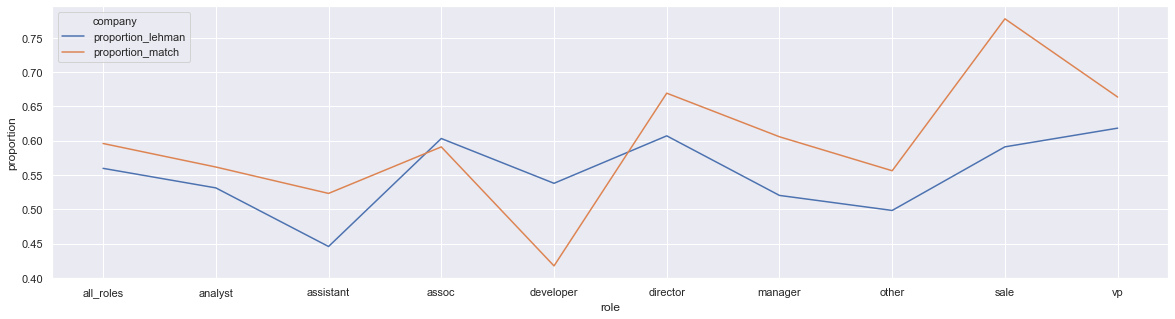

In [86]:
sns.set(rc={'figure.figsize':(20,5)})

sns.lineplot( x = 'role', y = 'proportion', hue = 'company', data = toPlot);

In [87]:
df.sort_values(by = 'role').to_csv('./Deliverables/proportion_finance.csv')

# Missing industries Lehman vs match

In [88]:
lehman_most_recent['lehman_missing_industry'] = pd.isnull(lehman_most_recent.industry)
lehman_most_recent['match_missing_industry'] = lehman_most_recent.match.apply(lambda x : match_to_missing_industry[x])

In [89]:
len(lehman_most_recent)

9631

In [90]:
(sum(lehman_most_recent.match_missing_industry), sum(lehman_most_recent.lehman_missing_industry))

(628, 707)

In [91]:
lehman_guys = lehman_most_recent[['lehman_stayed_finance']].copy().rename({'lehman_stayed_finance' : 'stayed_finance'}, axis = 1)

lehman_guys['is_lehman'] = 1

lehman_guys

non_lehman_guys = lehman_most_recent[['match_stayed_finance']].copy().rename({'match_stayed_finance' : 'stayed_finance'}, axis = 1)
non_lehman_guys['is_lehman'] = 0

all_data = pd.concat([lehman_guys,non_lehman_guys])

all_data

X = all_data['is_lehman']
y = all_data['stayed_finance']


model = sm.Probit(y, X)
results = model.fit()

results.get_margeff().summary()

Optimization terminated successfully.
         Current function value: 0.689568
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:         stayed_finance
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_lehman      0.0596      0.005     11.858      0.000       0.050       0.070
==============================================================================
"""

# Breaks

In [92]:
def prop_breaks(company_name, company_data):
    """
    Outputs proportion of "TIME_OFF" or "MISSING" entries in a
    dataset as the tuple (numerator, denominator).
    """

    def get_breaks():
        """
        Outputs the number of employees that have any "TIME_OFF" or "MISSING" entries after 2008.
        """
        date_2008 = pd.to_datetime('2008-01-01')
        # look only at data after 2008
        after_2008 = company_data[company_data['start'] > date_2008]
        # groupby user, aggregate by looking at the ticker and seeing if the person has had any time off
        return sum(after_2008.groupby('user').ticker.agg(lambda x: any((x == 'TIME_OFF') | (x == 'MISSING'))))
    
    num_company_users = len(company_data.groupby('user'))
    num_breaks = get_breaks()
    return company_name, num_breaks, num_company_users, num_breaks/num_company_users

drop = ['length', 'gender', 'primary',
        'primary_weight', 'secondary', 'secondary_weight',
        'city', 'country', 'education', 'elite', '.', '??',
        '/', 'department', 'exchange',
        'public', 'location_company', 'educational', 'degree', 'elite_education',
        'major', 'department', 'FIGI', 'last_update', 'name', 'birth','end', 'role',
        'company','normalized_company','industry']

breaks_data = {company_name : company_data.drop(labels=drop, axis=1) for company_name, company_data in data.items()}

lehman = breaks_data['leh'].copy()
date_2008 = pd.to_datetime('2008-01-01')
# look only at data after 2008
lehman = lehman[lehman['start'] > date_2008]
lehman = lehman[lehman.user.isin(list(lehman_to_match.keys()))]

lehman['match'] = lehman.user.apply(lambda x : lehman_to_match[x])
prop_breaks('leh', lehman)

('leh', 1342, 9516, 0.14102564102564102)

In [93]:
matches = list(lehman.match.unique())

non_lehman =  pd.concat([breaks_data['db'], breaks_data['gs'], breaks_data['ms'], breaks_data['ubs']])

non_lehman_matches = non_lehman[non_lehman.user.isin(matches)]

date_2008 = pd.to_datetime('2008-01-01')
# look only at data after 2008
after_2008 = non_lehman_matches[non_lehman_matches['start'] > date_2008]
# groupby user, aggregate by looking at the ticker and seeing if the person has had any time off
y = after_2008.groupby('user').ticker.agg(lambda x: any((x == 'TIME_OFF') | (x == 'MISSING')))

w = y.to_frame()

r = w[w.ticker == True]

r = list(r.index)

In [94]:
non_lehman_matches['took_break'] = False

non_lehman_matches.loc[non_lehman_matches.user.isin(r), 'took_break'] = True

user_to_break = dict(zip(non_lehman_matches.user, non_lehman_matches.took_break))

x = lehman.groupby('user').first()

x['break'] = x.match.apply(lambda x: user_to_break[x])

('other', sum(x['break']), len(x), sum(x['break'])/len(x))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


('other', 1369, 9516, 0.14386296763345943)

In [95]:
lehman_guys = lehman.groupby('user').first()
lehman_guys['break'] = lehman.groupby('user').ticker.agg(lambda x: any((x == 'TIME_OFF') | (x == 'MISSING'))).copy()

In [96]:
lehman_guys['is_lehman'] = 1
lehman_guys = lehman_guys[['break', 'is_lehman']]

In [97]:
non_lehman_guys = x[['break']].copy()
non_lehman_guys['is_lehman'] = 0

In [98]:
all_data = pd.concat([lehman_guys,non_lehman_guys])

all_data

X = all_data['is_lehman']
y = all_data['break']


model = sm.Probit(y, X)
results = model.fit()

results.get_margeff().summary()

Optimization terminated successfully.
         Current function value: 0.549984
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                  break
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_lehman     -0.3349      0.003   -115.426      0.000      -0.341      -0.329
==============================================================================
"""